# Visualisation des données de couverture nuageuse CloudSat
#### Couverture nuageuse de chaque étage, Evolution temporelle, cartes spatiales, coupes verticales


In [1]:
import os

import netCDF4 as nc

import math
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib import cm

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from myfunctions import *

from scipy import interpolate
from scipy.interpolate import griddata

In [2]:
######### EXTRACTION DES DONNEES DE COUVERTURE NUAGEUSE Cloud_Sat ##########

# Where to save images
rep0 = './quicklooks/'
# If the directory does not exist, we create it
if not(os.path.exists(rep0)):
    os.makedirs(rep0)

# Projection for plotting
proj = ccrs.LambertConformal(central_latitude = 37,
                             central_longitude = 10,
                             standard_parallels = (37, 37)
                             )

var1 = 'cll'
var2 = 'clm'
var3 = 'clh'
var4 = 'clt'

data4d = np.zeros((120,101,153,4))
i=0
for annee in range (2007,2017):
    for mois in range (1,13):
        if mois<10:
            fin = 'CF_LMH_CloudSat_CALIPSO_'+str(annee)+"0"+str(mois)+'_AAD50.nc'
        else :
            fin = 'CF_LMH_CloudSat_CALIPSO_'+str(annee)+str(mois)+'_AAD50.nc'
        d = nc.Dataset(fin)
        
        data1 = d[var1][:,:,:]
        data2 = d[var2][:,:,:]
        data3 = d[var3][:,:,:]
        data4 = d[var4][:,:,:]
        data4d[i,:,:,0] = data1[0,:,:]
        data4d[i,:,:,1] = data2[0,:,:]
        data4d[i,:,:,2] = data3[0,:,:]
        data4d[i,:,:,3] = data4[0,:,:]
        i=i+1

lat = d['lat'][:,:]
lon = d['lon'][:,:]

d.close()


##### -- to nan #####

data_filtre = np.zeros((120,101,153,4))
data_filtre[:] = np.nan

for k in range(120):
    for i in range(101):
        for j in range(153):
            for l in range(4):
                if data4d[k,i,j,l]>=0 and data4d[k,i,j,l]<=1:
                    data_filtre[k,i,j,l] = data4d[k,i,j,l]
                else:
                    data_filtre[k,i,j,l] = np.nan 
                
##### Supprime les mauvaises annees, à utiliser si on souhaite les donnees brutes non interpolees ######

data_filtre2 = np.zeros((120,101,153,4))
data_filtre2[:] = np.nan
for i in range(48):
	data_filtre2[i,:,:,:] = data_filtre[i,:,:,:]
for i in range(49,52):
	data_filtre2[i,:,:,:] = data_filtre[i,:,:,:]
for i in range(65,120):
	data_filtre2[i,:,:,:] = data_filtre[i,:,:,:]

In [4]:
##### RE INTERPOLATION SUR LA GRILLE ALADIN ######

# Suppression des valeurs aberrantes et des trous, méthode linéaire

#data_inter = (time,lat,lon,high)    le 4eme est la couverture totale
data_inter = np.zeros((120,101,153,4))
data_inter[:] = np.nan


for i in range(48):
    for j in range(4):
        xx = lon[np.isfinite(data_filtre[i,:,:,j])].ravel()
        yy = lat[np.isfinite(data_filtre[i,:,:,j])].ravel()
        dd = data_filtre[i,:,:,j][np.isfinite(data_filtre[i,:,:,j])].ravel()
        data_inter[i,:,:,j] = griddata((yy, xx),dd,(lat, lon), method='linear')
        
for i in range(49,52):
    for j in range(4):
        xx = lon[np.isfinite(data_filtre[i,:,:,j])].ravel()
        yy = lat[np.isfinite(data_filtre[i,:,:,j])].ravel()
        dd = data_filtre[i,:,:,j][np.isfinite(data_filtre[i,:,:,j])].ravel()
        data_inter[i,:,:,j] = griddata((yy, xx),dd,(lat, lon), method='linear')
        
for i in range(65,120):
    for j in range(4):
        xx = lon[np.isfinite(data_filtre[i,:,:,j])].ravel()
        yy = lat[np.isfinite(data_filtre[i,:,:,j])].ravel()
        dd = data_filtre[i,:,:,j][np.isfinite(data_filtre[i,:,:,j])].ravel()
        data_inter[i,:,:,j] = griddata((yy, xx),dd,(lat, lon), method='linear')


In [5]:
####### MOYENNE CLIMATO 2007-016 #########

# Temporal mean - season

data_season = np.zeros((4,10,101,153,4))
data_season[:] = np.nan

for i in range(10):
    if i==0:
        data_season[0,i,:,:] = np.nanmean(data_inter[(0+12*i):(2+12*i),:,:],axis=0)
    else:
        data_season[0,i,:,:] = np.nanmean(data_inter[(-1+12*i):(2+12*i),:,:],axis=0)
    data_season[1,i,:,:] = np.nanmean(data_inter[(2+12*i):(5+12*i),:,:],axis=0)
    data_season[2,i,:,:] = np.nanmean(data_inter[(5+12*i):(8+12*i),:,:],axis=0)
    data_season[3,i,:,:] = np.nanmean(data_inter[(8+12*i):(11+12*i),:,:],axis=0)

data_season_moy = np.nanmean(data_season,axis=1)

# Temporal mean _ anual

data_moy_inter = np.nanmean(data_inter,axis=0)

# Temporal_mean - month

data_month = np.zeros((12,10,101,153,4))
data_month[:] = np.nan

for i in range(10):
    for j in range(12):
        for k in range(4):
            data_month[j,i,:,:,k] = data_inter[(j+12*i),:,:,k]
        
data_month_moy = np.nanmean(data_month,axis=1)


##### determination de boites #####

nt,nlat,nlon = data1.shape

    
lat_min = 20
lat_max = 27
lon_min = -6
lon_max = 4

# find coords of nearest point in grid from point (TARGET_LAT, TARGET_LON)
    
target_x = []
target_y = []
 
for x in range(nlon):
    for y in range(nlat):
        if lat[y,x]>=lat_min and lat[y,x]<=lat_max and lon[y,x]>=lon_min and lon[y,x]<=lon_max:
            target_x.append(x)
            target_y.append(y)
                 

# Temporal mean - box

data_boite=np.zeros((12,len(target_x),4))
data_boite_moy=np.zeros((12,len(target_x),4))
  
for j in range(12):
    for k in range(len(target_x)):
        data_boite[j,k,:] =  data_month_moy[j,target_y[k],target_x[k],:] 

data_boite_moy = np.nanmean(data_boite,axis=1)

print(data_boite_moy)



/usr/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


[[0.01720418 0.08189047 0.24749485 0.25908656]
 [0.01623787 0.07601397 0.16981913 0.18487942]
 [0.02769003 0.11491661 0.21291099 0.2369426 ]
 [0.0167523  0.08816166 0.20486323 0.22860572]
 [0.03517519 0.167975   0.22444431 0.27750813]
 [0.02225785 0.15622612 0.16038754 0.21147151]
 [0.01794916 0.16135148 0.11358858 0.19501483]
 [0.02748446 0.19854825 0.13654056 0.23971973]
 [0.05280379 0.24496322 0.20824042 0.3165882 ]
 [0.03816875 0.16446569 0.22334082 0.29852308]
 [0.01504785 0.08182445 0.26887481 0.28684312]
 [0.01670717 0.08422174 0.29546275 0.30864097]]


Text(0.5,1,'Cloud Fraction (%) in Western Sahara (-6W,20N / 4E,27N) - 2007 to 2016')

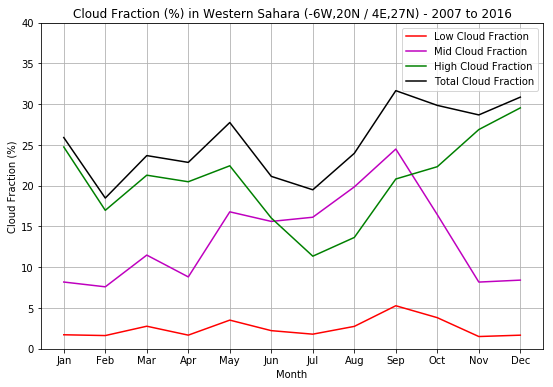

In [6]:
########## PLOT ###########
'''
fig=plt.figure(figsize=(12,8))
plt.plot(data_month_moy[:,58,63,0],label='Cll',color='r')
plt.plot(data_month_moy[:,58,63,1],label='Clm',color='m')
plt.plot(data_month_moy[:,58,63,2],label='Clh',color='g')
plt.plot(data_month_moy[:,58,63,3],label='Clt',color='k')
plt.legend()

print('lon=',lon[58,62])
print('lat=',lat[58,62])
'''
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig=plt.figure(figsize=(9,6))
plt.plot(months,data_boite_moy[:,0]*100,label='Low Cloud Fraction',color='r')
plt.plot(months,data_boite_moy[:,1]*100,label='Mid Cloud Fraction',color='m')
plt.plot(months,data_boite_moy[:,2]*100,label='High Cloud Fraction',color='g')
plt.plot(months,data_boite_moy[:,3]*100,label='Total Cloud Fraction',color='k')
plt.legend()
plt.ylim(0,40)
plt.grid()
plt.xlabel('Month')
plt.ylabel('Cloud Fraction (%)')
plt.title('Cloud Fraction (%) in Western Sahara (-6W,20N / 4E,27N) - 2007 to 2016')

Text(0.5,1,'Zonal vertical section - Cloud fraction (%) - Northern Europe - 2007 to 2016')

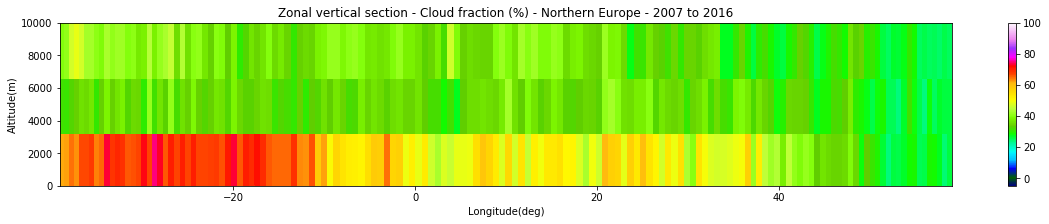

In [13]:
########## COUPES VERTICALES ##########

lat_coupe = 85
lon_coupe = 50

z = np.array([0,3200,6600,10000])
lat_liste=lat[:,lon_coupe]
lon_liste=lon[lat_coupe,:]
z_lat,lat_z = np.meshgrid(z,lat_liste)
z_lon,lon_z = np.meshgrid(z,lon_liste)

data_moy_inter2 = data_moy_inter
data_moy_inter2[:,:,3] = data_moy_inter2[:,:,2]


fig=plt.figure(figsize=(20,3))

#plt.contourf(lat_z[:,0:4],z_lat[:,0:4],data_moy_inter[:,lat_coupe,0:4]*100,vmin=0,vmax=100,\
#             levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],cmap=cm.gist_ncar)

plt.pcolormesh(lon_z[:,0:4],z_lon[:,0:4],data_moy_inter2[lat_coupe,:,0:4]*100,vmin=-5,vmax=100,cmap=cm.gist_ncar)
plt.xlabel('Longitude(deg)')
plt.ylabel('Altitude(m)')
plt.colorbar()
plt.title('Zonal vertical section - Cloud fraction (%) - Northern Europe - 2007 to 2016')


NameError: name 'bbox' is not defined

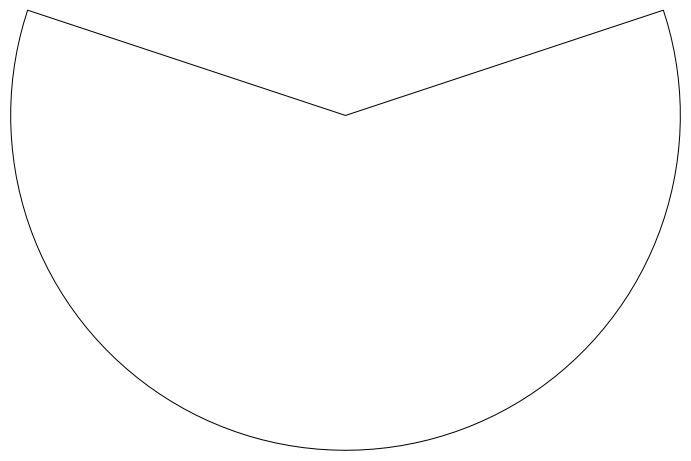

In [6]:
########## PLOTS CARTES ##########

# Domain to be plotted
bbox = [-24,44,14,56]

#Map projection is Lambert Conformal (proj)
fig, ax = plt.subplots(figsize=(12,10),subplot_kw=dict(projection=proj))
# Apply domain to be plotted
ax.set_extent(bbox,crs=ccrs.PlateCarree())
# Add coastlines
ax.coastlines('50m')
# Add country borders
ax.add_feature(cf.BORDERS)

# *must* call draw in order to get the axis boundary used to add ticks
fig.canvas.draw()

xticks = range(-180,181,10)
yticks = range(-90,91,10)
ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=1,color='dimgrey')

# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

#lambert_xticks(ax, xticks)
#lambert_yticks(ax, yticks)

#ax.set_title('{0} ({1}) - {2}'.format(name,units,dates[0]))
#ax.set_title('{0} ({1}) - 2007 to 2016'.format(name,units))
ax.set_title('{0} ({1})'.format("High Cloud Fraction CERES - 2007 to 2016","%"))


# Plot data
cs = ax.pcolormesh(lon,lat,data_moy_inter*100, transform=ccrs.PlateCarree(),
        cmap=cm.gist_ncar, vmin=0, vmax=100,shading='flat')

# Add colorbar
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal',pad=0.05)

# Save in png
#print '{0}/{1}'.format(rep0,var)+str(i+1)+'.png'
#plt.savefig('{0}/{1}_obs_moy.png'.format(rep0,var))
plt.show()
plt.close()


ValueError: too many values to unpack (expected 2)

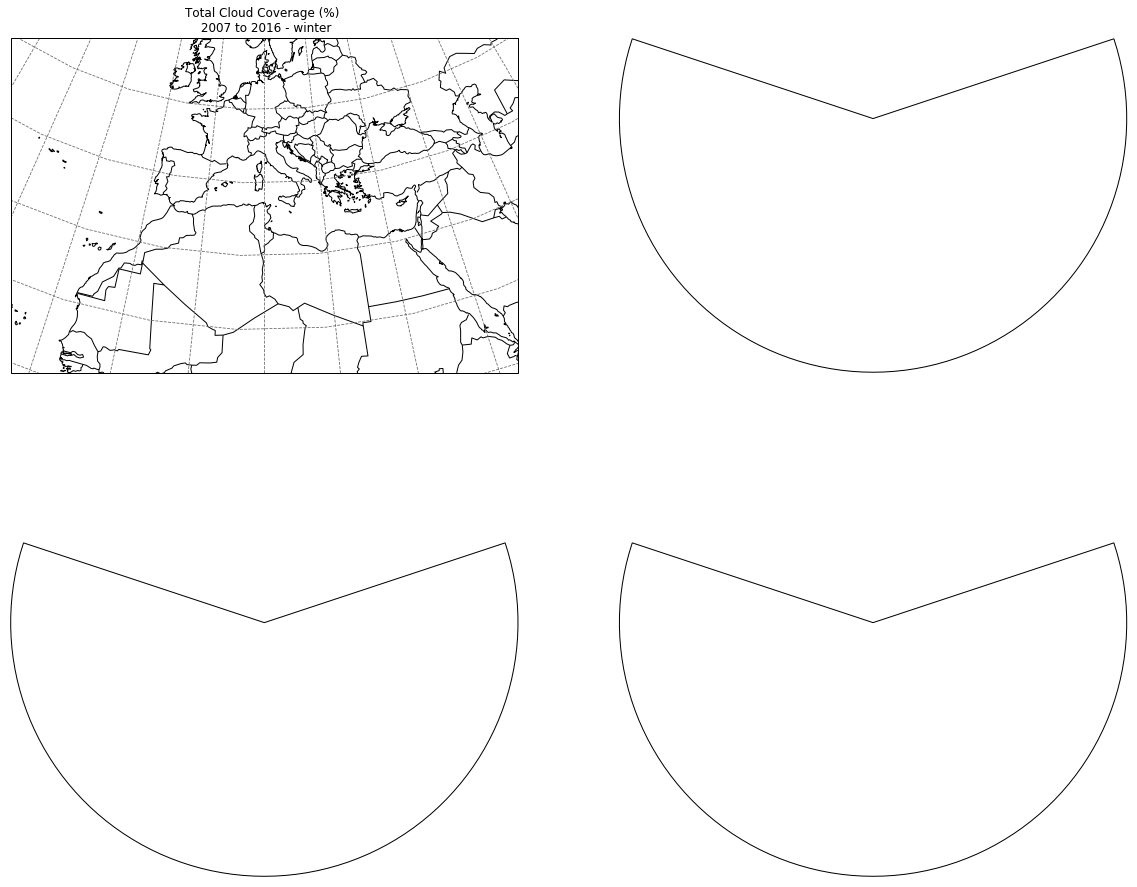

In [7]:
########## SUBPLOTS SEASONS ###########

# Domain to be plotted
bbox = [-24,44,14,56]

# Map projection is Lambert Conformal (proj)
fig, axes = plt.subplots(2,2,figsize=(20,17),subplot_kw=dict(projection=proj))
title_season = ['winter','spring','summer','fall']

for i, ax in enumerate(axes.flat):
	# Apply domain to be plotted
	ax.set_extent(bbox,crs=ccrs.PlateCarree())
		# Add coastlines
	ax.coastlines('50m')
	
		# Add country borders
	ax.add_feature(cf.BORDERS)
	
		# *must* call draw in order to get the axis boundary used to add ticks
	fig.canvas.draw()
	
	xticks = range(-180,181,10)
	yticks = range(-90,91,10)
	ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=1,color='dimgrey')
	
    	# Label the end-points of the gridlines using the custom tick makers:
	ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
	ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
	
	#lambert_xticks(ax, xticks)
	#lambert_yticks(ax, yticks)
	
	
	ax.set_title('Total Cloud Coverage (%) \n 2007 to 2016 - {0}'.format(title_season[i]))
	
    	# Plot data
	cs = ax.pcolormesh(lon,lat,data_season_moy[i,:,:]*100, transform=ccrs.PlateCarree(),
        			cmap=cm.gist_gray, vmin=0., vmax=100.,shading='flat')

# Add colorbar
fig.subplots_adjust(right=0.8, hspace=0.5)
cbar = fig.colorbar(cs, ax=axes[:,:], shrink=0.5, orientation='horizontal',pad=0.1)

# Save in png
plt.savefig('{0}/{1}_all_seasons_brut_3.png'.format(rep0,var))
plt.show()
plt.close()
